# Titanic

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV

### Loading data

In [3]:
df=pd.read_csv("train.csv")

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null int64
Deck           204 non-null object
AgeGroup       714 non-null category
FareGroup      888 non-null category
dtypes: category(2), float64(2), int64(7), object(4)
memory usage: 78.7+ KB


In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
def find_deck(cabin):
    try:
        match=re.search(r'[A-Z]',str(cabin))
        return match.group()
    except AttributeError:
        return np.nan

In [64]:
df["Deck"]=df["Cabin"].apply(find_deck)
df["Sex"]=df["Sex"].apply(lambda x: 1 if (x=="male" or x==1) else 0).values
df["AgeGroup"]=pd.cut(df["Age"],range(0,81,10),right=True)
df["FareGroup"]=pd.cut(df["Fare"],range(0,301,25),right=False)
df["Embarked"]=df["Embarked"].apply(lambda x: 1 if x=="C" else 2 if x=="Q" else 3)
df["Age"]=df["Age"].fillna(0)

In [65]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,AgeGroup,FareGroup
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,3,NaN,"(20, 30]","[0, 25)"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,3,C,"(30, 40]","[50, 75)"
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,3,NaN,"(20, 30]","[0, 25)"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,3,C,"(30, 40]","[50, 75)"
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,3,NaN,"(30, 40]","[0, 25)"


### Exploratory visualisation

In [10]:
features=["Sex","Pclass","AgeGroup","FareGroup","Deck","SibSp","Parch","Embarked"]

In [11]:
d={}
for f in features:
    temp=df.groupby(["Survived",f]).size()
    d[f]=pd.concat([temp[0],temp[1]],axis=1).fillna(0)

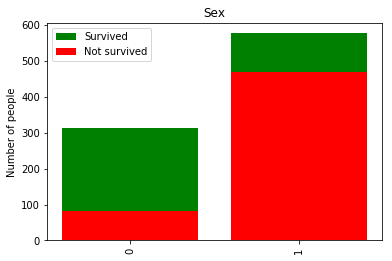

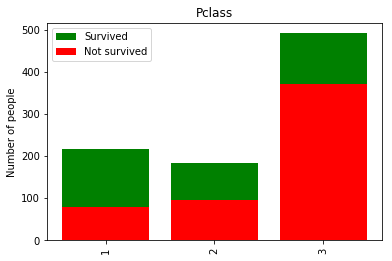

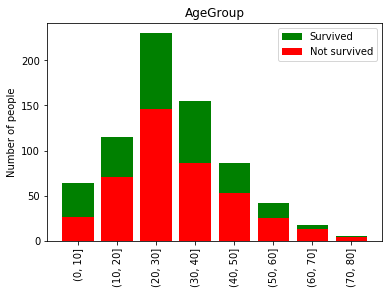

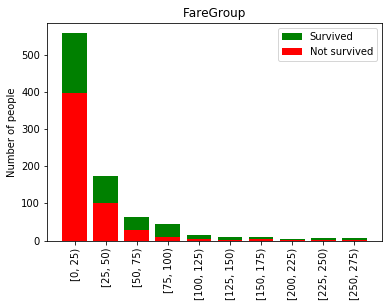

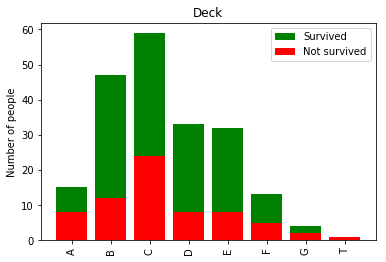

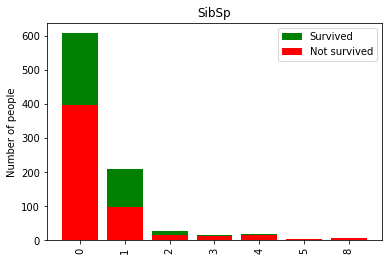

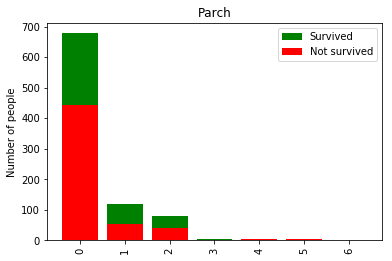

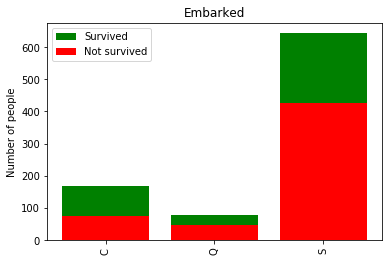

In [12]:
for f in features:
    plt.bar(np.arange(len(d[f][1])),d[f][1],bottom=d[f][0],label="Survived",color="g")
    plt.bar(np.arange(len(d[f][0])),d[f][0],label="Not survived",color="r")
    plt.xticks(np.arange(len(d[f][0])),d[f].index.values,rotation=90)
    plt.ylabel("Number of people")
    plt.title(f)
    plt.legend()
    plt.show()
    

### Machine learning

In [67]:
features=["Sex","SibSp","Pclass","SibSp","Parch","Fare","Age","Embarked"]
#features=["Sex","Pclass","Fare"]
labels=["Survived"]

X_train,X_test,y_train,y_test=train_test_split(df[features],df[labels],test_size=0.3,random_state=42)

In [61]:
def do_classify(clf_single,parameters):
    clf=GridSearchCV(clf_single,parameters)
    clf.fit(X_train,y_train)
    pred=clf.predict(X_test)
    print features
    print confusion_matrix(y_test,pred)
    print accuracy_score(y_test,pred)
    print clf.best_params_
    

#### Decision Tree

In [68]:
tree=DecisionTreeClassifier()
parameters={"max_depth":[1,2,3,4,None],"min_impurity_decrease":[0,0.1,0.2],"min_samples_leaf":[2,3,4]}
do_classify(tree,parameters)

['Sex', 'SibSp', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Age', 'Embarked']
[[141  16]
 [ 35  76]]
0.809701492537
{'min_impurity_decrease': 0, 'max_depth': 3, 'min_samples_leaf': 2}


#### Support Vector Machine

In [34]:
parameters_svm={"C":[0.7,0.9,1,1.1,1.3],"gamma":[0.3,0.5,0.6,0.9,1,1.1,1.5]}
do_classify(SVC(),parameters_svm)

['Sex', 'Pclass', 'Fare']
[[138  19]
 [ 32  79]]
0.809701492537
{'C': 1.1, 'gamma': 0.5}


#### AdaBoost

In [36]:
parameters_AB={"learning_rate":[0.8,0.9,1,1.1,1.2]}
do_classify(AdaBoostClassifier(),parameters_AB)

['Sex', 'Pclass', 'Fare']
[[133  24]
 [ 30  81]]
0.798507462687
{'learning_rate': 0.9}


#### Random Forest Classifier

In [71]:
parameters_RF={"n_estimators":[1,10,50,100],"max_depth":[None,3,6,8,10,12],"random_state":[42]}
do_classify(RandomForestClassifier(),parameters_RF)

['Sex', 'SibSp', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Age', 'Embarked']
[[141  16]
 [ 40  71]]
0.791044776119
{'n_estimators': 50, 'random_state': 42, 'max_depth': 8}


### Visualize predictions